In [1]:
from os.path import dirname, abspath,join
import sys
import numpy as np
import pandas as pd
import json
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from typing import List

root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)
from prochain_transformer.predict import *

## Batch-level

In [3]:
datadir_path = r"../data/input"
config_path = r"../experiments/training/dx_batch_std_cat_20emb20mod/config.yaml"
checkpoint_path = r"../experiments/training/dx_batch_std_cat_20emb20mod/k_0/checkpoints/epoch=999-train_loss=0.00.ckpt"

external_dataset =  {
    "dataset":"ds_dx_pred_std_MSI_01_01_2022-07_07_2025",
    "filename_input": "X.npy",
    "filename_target": "Y.npy",
}

config = OmegaConf.load(config_path)
input_array, output_array, target_array, cross_att_array = predict_test_from_ckpt(
    config, 
    datadir_path, 
    checkpoint_path, 
    external_dataset,
    dataset_label="all", 
    cluster=False
    )

Global seed set to 42


c:\ProgramData\anaconda3\envs\prochain_transformer\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.0.3
  rank_zero_warn(
c:\ProgramData\anaconda3\envs\prochain_transformer\Lib\site-packages\torch\utils\data\dataset.py:449: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


All data selected (default).
Predicting...


100%|██████████| 1/1 [00:05<00:00,  5.55s/it]


In [80]:
# files
dataset_name = external_dataset["dataset"][3:]
builds_dir = "../../process_pipeline/data/builds"
var_vocab_filepath = join(builds_dir, dataset_name, "output/variables_vocabulary.json_trg")
var_vocab_input_filepath = join(builds_dir, dataset_name, "output/variables_vocabulary.json_input")
pos_vocab_filepath = join(builds_dir, dataset_name, "output/position_vocabulary.json")
batch_vocab_filepath = join(builds_dir, dataset_name, "output/batch_vocabulary.json")
rating_filepath = join(builds_dir, dataset_name, "control/steps_selected.xlsx")

with open(var_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_var_dict = json.load(file)
    
with open(var_vocab_input_filepath, 'r', encoding='utf-8') as file:
    inv_var_input_dict = json.load(file)
    
with open(pos_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_pos_dict = json.load(file)
    
with open(batch_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_batch_dict = json.load(file)

df_rating = pd.read_excel(rating_filepath)

# maps
var_map = {v: k[:3] for k, v in inv_var_dict.items()}
var_input_map = {v: k for k, v in inv_var_input_dict.items()}
pos_map = {v: int(float(k)) for k, v in inv_pos_dict.items()}
batch_map = {v: k for k, v in inv_batch_dict.items()}
rate_map = df_rating.set_index("Step")["Bewertung "].to_dict()
process_map = df_rating.set_index("Step")["Process"].to_dict()


# define data indices
var_index = 2
x_index = 3
val_index = 4

# get variables
vars = np.unique(target_array[:,:,var_index])
vars = vars[~np.isnan(vars)]
num_vars = len(vars)

In [105]:
batch_map

{0: 'CYDH', 1: 'CYEI', 2: 'DAQN'}

In [81]:
plot_var_map = {
    "Sense A": {
        "mean":1,
        "std":2
        },
    "Sense B": {
        "mean" : 3,
        "std" : 4
        }
    }

In [82]:
trained_trg = np.load("../data/input/ds_dx_250711_batch_200_std_clip/Y.npy")
mask_senseA_std = trained_trg[:,:,var_index] == 2
mask_senseB_std = trained_trg[:,:,var_index] == 4
senseA_baseline = np.median(trained_trg[mask_senseA_std,val_index])
senseB_baseline = np.median(trained_trg[mask_senseB_std,val_index])
baselines = [senseA_baseline,senseB_baseline]
print(f"Sense A std baseline: {senseA_baseline}")
print(f"Sense A std baseline: {senseB_baseline}")

Sense A std baseline: 0.0427034278850235
Sense A std baseline: 0.0452519844434733


In [83]:
trained_trg[mask_senseA_std,val_index]

array([0.        , 0.00705354, 0.00817581, ..., 0.22756983, 0.22889218,
       0.23087067])

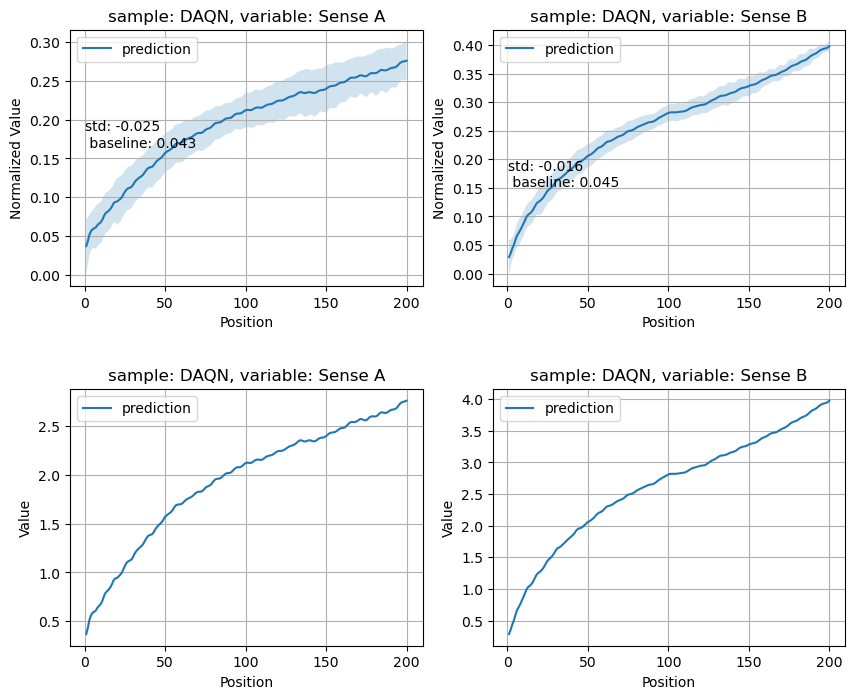

In [110]:
def plot_predictions(
    sample_id: int, 
    var_index: int,
    plot_var_map: dict, 
    target_array: np.ndarray,
    output_array: np.ndarray,
    plot_target: bool = True,
    batch_map: dict = None,
    var_map: dict=None,
    norm_scale:float=10,
    save: bool=False):
    
    
    # vars = np.unique(plot_var_map.keys())
    num_vars = len(plot_var_map.keys())
    
    
    fig = plt.figure(figsize=(5*num_vars, 8))
    gs = gridspec.GridSpec(2, num_vars, hspace=.4)

    for i,var in enumerate(plot_var_map.keys()):
        
        
        
        var_mean_mask = target_array[sample_id, :, var_index] == plot_var_map[var]["mean"]
        var_std_mask = target_array[sample_id, :, var_index] == plot_var_map[var]["std"]
        
        
        
        x = target_array[sample_id, :, x_index][var_mean_mask]
        y_mean = output_array[sample_id,var_mean_mask]
        y_std = output_array[sample_id,var_std_mask]
        
        
        ax_norm = fig.add_subplot(gs[0,i])
        ax_norm.fill_between(x,y_mean-y_std,y_mean+y_std, alpha=0.2)
        ax_norm.plot(x, y_mean, label="prediction")
        #ax_norm.plot(x,y_std)
        
        text = f"std: {np.median(y_std):.3f} \n baseline: {baselines[i]:.3f}"
        ax_norm.text(.2,.2,text,va="top")
        
        if plot_target:
            y_trg = target_array[sample_id, :, val_index][var_mean_mask]
            ax_norm.plot(x, y_trg, label="target")
        
        ax_norm.grid(True)
        ax_norm.set_ylabel("Normalized Value")
        ax_norm.set_xlabel("Position")
        
        title_batch = batch_map[sample_id] if batch_map is not None else sample_id
        title_var = var_map[var] if var_map is not None else var
        
        ax_norm.set_title(f"sample: {title_batch}, variable: {title_var}")
        ax_norm.legend()
        
        
        ax_abs = fig.add_subplot(gs[1,i])
        ax_abs.plot(x, y_mean*norm_scale, label="prediction")
        
        if plot_target:
            y_trg = target_array[sample_id, :, val_index][var_mean_mask]
            ax_abs.plot(x, y_trg*norm_scale, label="target")
        
        ax_abs.grid(True)
        ax_abs.set_ylabel("Value")
        ax_abs.set_xlabel("Position")
        
        title_batch = batch_map[sample_id] if batch_map is not None else sample_id
        title_var = var_map[var] if var_map is not None else var
        
        ax_abs.set_title(f"sample: {title_batch}, variable: {title_var}")
        ax_abs.legend()
        
        
    if save:
        fig.savefig("prediction.png", dpi=300, bbox_inches='tight')
    
    plt.show()
    


sample_id = 2

plot_predictions(
    sample_id= sample_id, 
    var_index= var_index,
    plot_var_map=plot_var_map, 
    target_array=target_array,
    output_array=output_array,
    plot_target = False,
    batch_map = batch_map,
    var_map =None,
    norm_scale =10,
    save=False)

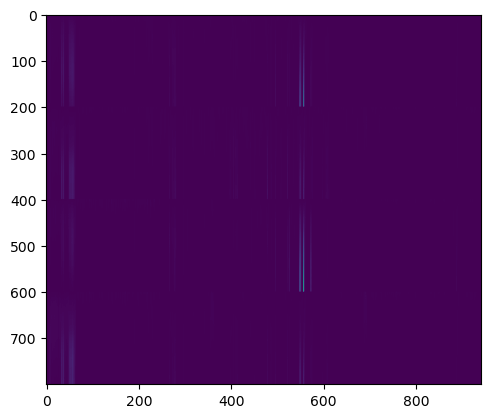

In [103]:
plt.imshow(cross_att_array[sample_id,:,:])

In [104]:
max_att_idx = np.argmax(np.mean(cross_att_array[sample_id,:,:],axis=0))

var_input_map[input_array[sample_id,max_att_idx,var_index]]

'gal_62'

# Panel-level